<a href="https://colab.research.google.com/github/GUNTERMAXIMUS/mbti/blob/master/MBTI_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MBTI PREDICTIONS**

sources and docs to look up:
* https://donche.github.io/en/2017/12/27/mbti_blog.html

* https://github.com/adjl/MBTI/blob/master/code_snippets.py

* https://github.com/bvannah/wellfie

* https://sararobinson.dev/2019/04/23/interpret-bag-of-words-models-shap.html

* https://github.com/ianscottknight/Predicting-Myers-Briggs-Type-Indicator-with-Recurrent-Neural-Networks

* https://cloud.google.com/ml-engine/docs/python-client-library?hl=es-419

* https://github.com/llSourcell/Learn_Machine_Learning_in_3_Months

* https://towardsdatascience.com/multi-class-text-classification-with-lstm-using-tensorflow-2-0-d88627c10a35

* https://medium.com/qu4nt/reducir-el-n%C3%BAmero-de-palabras-de-un-texto-lematizaci%C3%B3n-y-radicalizaci%C3%B3n-stemming-con-python-965bfd0c69fa

* https://towardsdatascience.com/text-cleaning-methods-for-natural-language-processing-f2fc1796e8c7

* https://nlpforhackers.io/complete-guide-to-spacy/

* https://www.datacamp.com/community/tutorials/stemming-lemmatization-python
* https://www.guru99.com/stemming-lemmatization-python-nltk.html

---
# **1. Libraries**
---

**Tensorflow**

In [0]:
import warnings

try:
  %tensorflow_version 2.x # specifying the TensorFlow version to google colab
except Exception:
  warnings.warn('You are not using your specify version of TensorFlow')
finally:
  import tensorflow as tf
  from tensorflow import keras
  from tensorflow.keras.preprocessing.text import Tokenizer # to preprocess using tokenizer
  from tensorflow.keras.preprocessing.sequence import pad_sequences # to pad sequences
  print(f'TF version: {tf.__version__}')

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # specifying the TensorFlow version to google colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
TF version: 2.1.0


**Manipulation & preprocessing data libs**

In [0]:
# Manipulation
import pandas as pd # to dataset (csv) manipulation
import numpy as np # to array
from collections import Counter

import re

# Natural Language Preprocessing
# Stopwords
import nltk # Natural Language ToolKit
nltk.download('stopwords')
from nltk.corpus import stopwords # to get rid of StopWords 

# Lemmatization
!spacy download es_core_news_sm # sm md
import spacy
#spacy.prefer_gpu() # Error

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


**Graphs libs**

In [0]:
import matplotlib.pyplot as plt # to create graphs

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # to create a Word Cloud
from PIL import Image # Pillow with WordCloud to image manipulation

---
# **2. Drive Mount for Google Colab**
---

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

root_path = 'gdrive/My Drive/Colab Notebooks/MBTI/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


---
# **3. Reading file and making bigger dataset**
---
reading csv file and improving it, making a bigger dataset.


# **3.1. Reading the file**

In [0]:
# Reading the file
path_root = 'gdrive/My Drive/Colab Notebooks/MBTI/'
root_fn = path_root + 'mbti_datasets.csv'
df = pd.read_csv(root_fn, sep = ',', quotechar = '"', usecols = [0, 1])

# **3.2. Making a bigger dataset**
Every `\n` will create another row (descripcion) with their respective id (tipo).

In [0]:
# split the column where there are new lines and turn it into a series
serie = df['descripcion'].str.split('\n').apply(pd.Series, 1).stack()

# remove the second index for the DataFrame and the series to share indexes
serie.index = serie.index.droplevel(1)

# give it a name to join it to the DataFrame
serie.name = 'descripcion'

# remove original column
del df['descripcion']

# join the series with the DataFrame, based on the shared index
df = df.join(serie)

# shuffle DF, so we will have random indexes
df = df.sample(frac=1).reset_index(drop=True)

# **3.3. Writing a new DataFrame**
Creating a new csv file with bigger dataset:
* dropping NaN values.
* applying lower case to the second column ('descripcion'). 

In [0]:
# New file name and writing the new csv file
root_new_fn = path_root + 'mbti_new.csv'

# Creating a new DataFrame to csv, dropping the NaN values
df.to_csv(root_new_fn, sep = ',', quotechar = '"', encoding = 'utf-8', index = False)
new_df = pd.read_csv(root_new_fn).dropna()

# Conveting 'descripcion' column to lower case
new_df['descripcion'] = new_df['descripcion'].str.lower()

In [0]:
# Remove characters and numbers [^0-9A-Za-z \t] [^0-9A-Za-zÁ-Úá-ú \t]
new_df['descripcion'] = new_df['descripcion'].apply(lambda elem: re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-zÁ-Úá-ú \t])|(\w+:\/\/\S+)|^rt|http.+?%', '', elem))
new_df['descripcion'] = new_df['descripcion'].apply(lambda elem: re.sub(r'\d+', '', elem))

# Rewriting the created file without NaN values
new_df.to_csv(root_new_fn, sep = ',', quotechar = '"', encoding = 'utf-8', index = False)

# Reading: bigger dataset without NaN values
new_df = pd.read_csv(root_new_fn)

In [0]:
# Checking if there's any NaN value
isnull = [i for i in (new_df['descripcion'].isnull()) if i == True]
if isnull != []:
  print(isnull)
else:
  print(len(new_df['tipos'].value_counts()))
  print(new_df['tipos'].value_counts())

---
# **4. Manipulating the data**
---

# **4.1. Stopwords NLTK**

In [0]:
new_stopwords = ['arquitecto', 'solo', 'persona', 'personalidad', 'tipo', 'punto', 'comandante',
                 'lógico', 'innovador', 'abogado', 'mediador', 'protagonista',
                 'activista', 'puede', 'debater', 'logista', 'defensor', 'ejecutivo',
                 'cónsul', 'virtuoso', 'aventurero', 'emprendedor', 'animador']

stop_words = stopwords.words('spanish') 
stop_words.extend(new_stopwords)

stop_words = set(stop_words)

new_df['descripcion'] = new_df['descripcion'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

#new_df['descripcion'] = new_df['descripcion'].str.contains('persona', case=False).astype(int)
print(new_df.iloc[3, 1])

teorías conceptos abstractos largas discusiones temas globales consecuencias captarán interés emprendedora tiempo emprendedores hablan mucha energía buena dosis inteligencia gusta hablar cosas mejor aún simplemente hacerlas emprendedores lanzan acción pensar corrigen errores marcha lugar sentarse hacer preparan imprevistos disponen soluciones nunca confundir movimiento acción


# **4.2. Lemmatization SpaCy**

In [0]:
nlp = spacy.load('es_core_news_sm') #sm md

def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

#new_df['descripcion'] = new_df['descripcion'].apply(lambda x: lemmatizer(x))
text = 'personas, ideas, cosas'
print(lemmatizer(text))

personar , ideo , coser


# **4.3. Splitting the data into x and y**
spliting the data into x (description or train data) and y (labeles or personality types)

In [0]:
# Representing the DataFrame simply as data
data = new_df

# Getting the columns (tipos and descripcion) as strings into pandas.core.series.Series object.
(x_train, y_train) = (data.descripcion, data.tipos)
# Getting the columns as np.arrays
train_data_arr = np.array(list(x_train))
train_labels_arr = np.array(list(y_train))

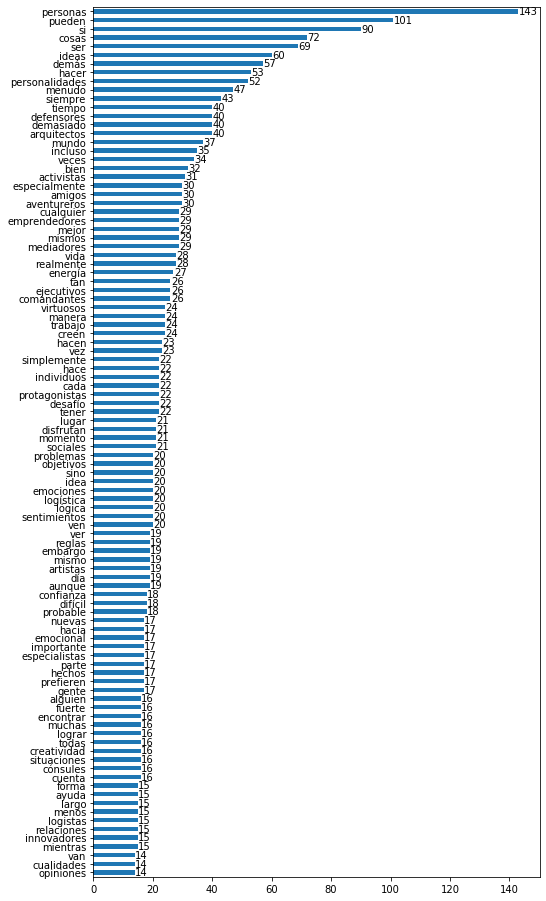

In [0]:
def histogram(text, N = 100):
  if text == list(text):
    text = ' '.join(text)
  
  words = text.split()
  counts = Counter(words)
  serie = pd.Series(counts) # convert dictionary to pandas Series object

  # sort the values (in ascending order) of the serie and select the N most frequent words
  first_N = serie.sort_values().tail(N) # similar to most_common but most efficient, because calculates the frecuencies just once.
  
  ax = first_N.plot.barh(figsize=(8, 16)) # make the horizontal bar plot, set the size of the figure
  i = 0
  xoffset = 0.1 # value to adjust the text label
  for v in first_N.values:
    # adds the text next to each bar
    ax.text(y=i, x=v + xoffset, s=v, ha='left', va='center') 
    i += 1

train_data_text = ' '.join(train_data_arr)
counter = [j for j, k in (Counter(train_data_text.split()).most_common(150))]
no_dupl = [elem for elem in list(stop_words) if elem not in counter]

histogram(train_data_text) # takes words with ,s

# **4.4. Assigning percentages to training & validation data**

In [0]:
# We assign of the train_data, 80% for training and 20% for validation 
train_size = int(len(train_data_arr) * 0.8) # 80%

# 0 to 80%
train_data = train_data_arr[:train_size]
train_labels = train_labels_arr[:train_size]

# 80% to end
val_data = train_data_arr[train_size:]
val_labels = train_labels_arr[train_size:]

print('\nReal size: TRAIN vs VALIDATION')
print(f'80% = {len(train_data)}  | 20% = {len(val_data)}')


Real size: TRAIN vs VALIDATION
80% = 236  | 20% = 59


# **4.5. Wordcloud: medium unclean train_data**
Creating and displaying unclean train_data into a wordcloud.

**At this point:**
* **lower case** was applied to every description.
* **STOPWORDS** were removed.
* **Lemmatization** applied.
* data **splitted** (training (x), validation (y)).
* **percentages** added to the data splitted.



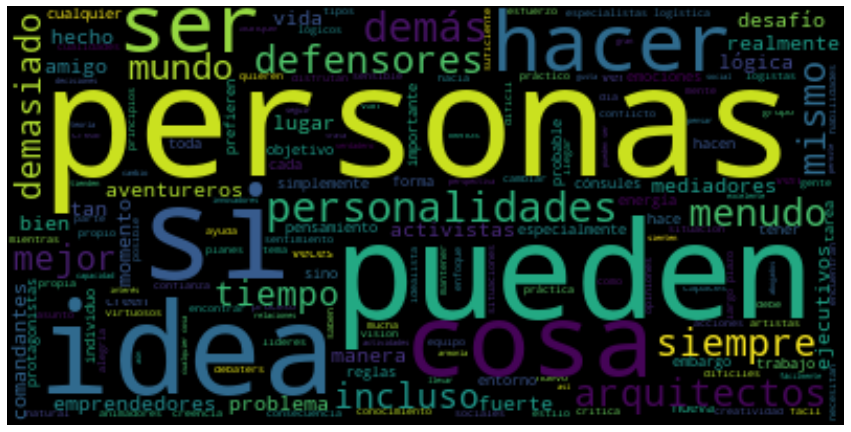

In [0]:
# Train data to list
train_data_list = list(train_data)

# Train data list to text
train_data_text = ' '.join([str(elem) for elem in train_data_list])

# Create and generate a wordcloud image
wordcloud_unclean = WordCloud(background_color="black").generate(train_data_text)

# Display the generated image:
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud_unclean, interpolation='bilinear')
plt.axis("off")
plt.show()

---
# **5. Preprocessing the train_data**
---

# **5.1. Tokenization of train data:**

In [0]:
filter_char = '-{|*+}][<=>@^_~“”,.()\"/:#$%&;""%?¿!¡´`\u200b\n\r\t' # \u200b unicode unrecognised a space

`.fit_on_texts(texts)`: updates internal vocabulary based on a list of texts. In the case where texts contains lists, we assume each entry of the lists to be a token.

Required before using texts_to_sequences or texts_to_matrix.

In [0]:
# with OOV the tokenizer will create a token for words which does not recognize on the test_data (from the train data)
tokenizer = Tokenizer(num_words = 5000,
                      filters = filter_char,
                      lower = True,
                      split = ' ',
                      oov_token  = '<OOV>') 
# Tokenizer
tokenizer.fit_on_texts(train_data)

# Indexing each word from the tokenized x_train_data_array
word_index = tokenizer.word_index

# Reversing word index value:keys (1:palabra)
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print(reverse_word_index)



{1: '<OOV>', 2: 'personas', 3: 'pueden', 4: 'si', 5: 'cosas', 6: 'ser', 7: 'ideas', 8: 'personalidades', 9: 'demás', 10: 'hacer', 11: 'arquitectos', 12: 'menudo', 13: 'siempre', 14: 'defensores', 15: 'tiempo', 16: 'demasiado', 17: 'mundo', 18: 'mejor', 19: 'incluso', 20: 'emprendedores', 21: 'aventureros', 22: 'bien', 23: 'mediadores', 24: 'energía', 25: 'amigos', 26: 'veces', 27: 'tan', 28: 'cualquier', 29: 'realmente', 30: 'mismos', 31: 'comandantes', 32: 'activistas', 33: 'ejecutivos', 34: 'lugar', 35: 'especialmente', 36: 'manera', 37: 'desafío', 38: 'creen', 39: 'tener', 40: 'vida', 41: 'vez', 42: 'hacen', 43: 'individuos', 44: 'idea', 45: 'trabajo', 46: 'hace', 47: 'día', 48: 'sociales', 49: 'momento', 50: 'lógica', 51: 'logística', 52: 'cónsules', 53: 'cada', 54: 'ven', 55: 'simplemente', 56: 'embargo', 57: 'objetivos', 58: 'reglas', 59: 'protagonistas', 60: 'ver', 61: 'sentimientos', 62: 'emociones', 63: 'prefieren', 64: 'sino', 65: 'especialistas', 66: 'probable', 67: 'difícil

# **5.2. Wordcloud: preprocessed clean train_data**
Creating and displaying clean preprocessed train_data into a wordcloud.

**At this point:**
* all the points from the previous wordcloud.
* **tokenization** applied.

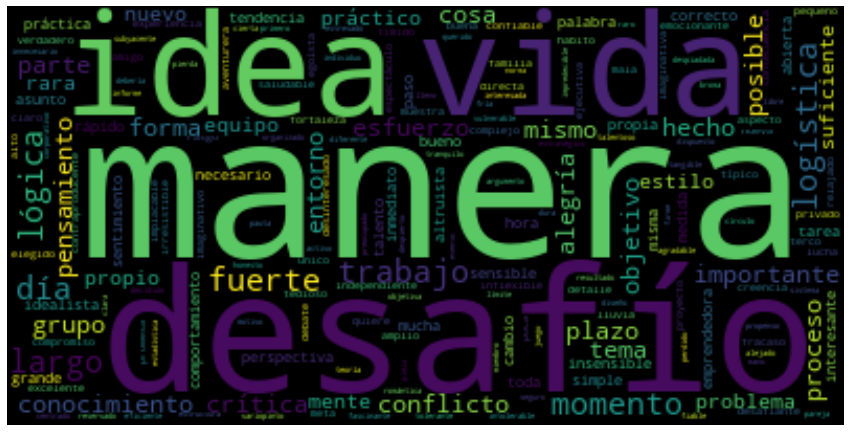

In [0]:
# Getting the word_index list into string
word_index_text = ' '.join([str(elem) for elem in word_index])

# Creating and displaying the wordcloud with clean train_data
wordcloud1 = WordCloud(background_color="black").generate(word_index_text)
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

# **5.3. Text to sequences**
After tokenization, the next step is to turn those tokens into lists of sequence.

In [0]:
train_data_sequences = tokenizer.texts_to_sequences(train_data)

# **5.4. Padding the train data**
When we train neural networks for NLP, we need sequences to be in the same size, that’s why we use padding.

In [0]:
train_data_padded = tf.keras.preprocessing.sequence.pad_sequences(
  train_data_sequences,
  maxlen = 240,
  dtype = 'int32',
  padding = 'post',
  truncating = 'post', # remove values from sequences larger than maxlen
  value = 0.0)

---
# **6. Preprocessing the validation_data**
---

# **6.1. Text to sequence & padding validation**

In [0]:
# Tokenization, validation text to sequences
validation_sequences = tokenizer.texts_to_sequences(val_data)

# Padding the validation data
validation_padded = tf.keras.preprocessing.sequence.pad_sequences(validation_sequences,
                                                                  maxlen = 240,
                                                                  dtype = 'int32',
                                                                  padding = 'post',
                                                                  truncating = 'post',
                                                                  value = 0.0)

---
# **7. Preprocessing the labels: tokenization**
---

# **7.1. Tokenization train_labels**

In [0]:
# creating a new instace
label_tokenizer = Tokenizer()

# Tokenization:
# updates internal vocabulay based on a list of text
# each entry of into a list is assumed to be a token
# requiered before using text sequences
label_tokenizer.fit_on_texts(train_labels_arr)

In [0]:
train_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(val_labels))

---
# **8. Analizing data before training**
---


# **8.1. Reverse_word_index** 
before training deep neural network, we should explore what our original text after padding look like.

In [0]:
def decode(data):
	""" decode the training and testing data into readable words"""
	return ' '.join([reverse_word_index.get(i, '<PAD>') for i in data]) # get index i, if we can't find a value for i, then we put ?

print(decode(train_data_padded[7]))
print(decode(validation_padded[1]))

demasiado centrado estatus social ejecutivos enorgullecen respeto amigos colegas comunidad aunque difíciles admitir preocupados opinión pública ejecutivos especialmente turbulentos pueden quedar tan atrapados cumplimiento expectativas demás satisfacen propias necesidades <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

# **8.2. Analizing to debug**

In [0]:
print(f'''
LENGTH:
ITEM.
1. training padded: {len(train_data_padded[0])}
2. validation padded: {len(validation_padded[0])}

TENSOR.
1. training padded: {len(train_data_padded)}
2. validation padded: {len(validation_padded)}

SIZE:
ITEM.
1. training padded: {train_data_padded[0].size}
2. validation padded: {validation_padded[0].size}

TENSOR.
1. training padded: {train_data_padded.size}
2. validation padded: {validation_padded.size}


DIMENSIONS:
1. training padded: {train_data_padded.ndim}
2. validation padded: {validation_padded.ndim}

SHAPE:
1. training padded: {train_data_padded.shape}
2. validation padded: {validation_padded.shape}

''')



LENGTH:
ITEM.
1. training padded: 240
2. validation padded: 240

TENSOR.
1. training padded: 236
2. validation padded: 59

SIZE:
ITEM.
1. training padded: 240
2. validation padded: 240

TENSOR.
1. training padded: 56640
2. validation padded: 14160


DIMENSIONS:
1. training padded: 2
2. validation padded: 2

SHAPE:
1. training padded: (236, 240)
2. validation padded: (59, 240)




---
# **9. Creating the model: LSTM**
---

In [0]:
model = keras.Sequential()
model.add(keras.layers.Embedding(input_dim = 56640, output_dim = 64)) # vocabulary size (expecting at least: 236 * 240)
# The output from Bidirectional is 128, because it doubled what we put in LSTM. 
model.add(keras.layers.Bidirectional(keras.layers.LSTM(64))) # model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(64, activation = 'relu'))
model.add(keras.layers.Dense(6, activation = 'softmax')) # sigmoid | softmax

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          3624960   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 3,699,654
Trainable params: 3,699,654
Non-trainable params: 0
_________________________________________________________________


---
# **10. Training the model**
---

In [0]:
fitModel = model.fit(train_data_padded, train_label_seq,
					 epochs = 10,
					 batch_size = 295, #how many we will load it at once (number of samples per gradient)
					 validation_data = (validation_padded, validation_label_seq), #(x_val, y_val) validation_padded, validation_label_seq
					 verbose = 1)

Train on 236 samples, validate on 59 samples
Epoch 1/10
236/236 [==============================] - 4s 15ms/sample - loss: nan - accuracy: 0.0720 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/10
236/236 [==============================] - 0s 438us/sample - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/10
236/236 [==============================] - 0s 481us/sample - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/10
236/236 [==============================] - 0s 316us/sample - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/10
236/236 [==============================] - 0s 366us/sample - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/10
236/236 [==============================] - 0s 343us/sample - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/10
236/236 [==============================] - 0s 337us/sample - 

---
# **11. Graph of the trained model**
---

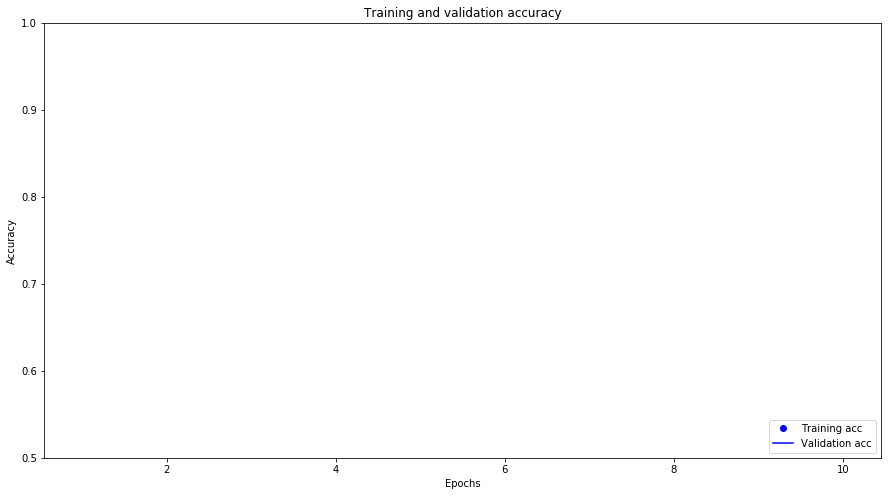

In [0]:
fitModel_dict = fitModel.history
acc = fitModel_dict['accuracy']
val_acc = fitModel_dict['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 8))
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.ylim((0.5, 1)) #tupla
plt.show()

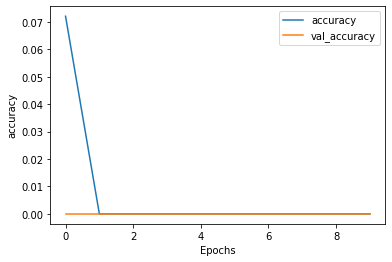

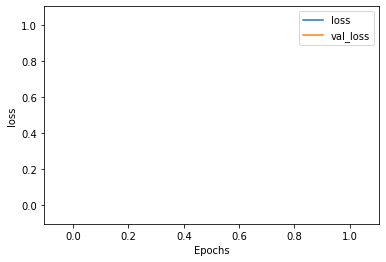

In [0]:
def plot_graphs(fitModel, string):
  plt.plot(fitModel.history[string])
  plt.plot(fitModel.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(fitModel, "accuracy")
plot_graphs(fitModel, "loss")

In [0]:
#results = model.evaluate(test_data_padded, test_labels)
#print(results)

---
# **12. Saving and loading the model**
---


In [0]:
# Save the model in binary data: able to read it in quickly and use the model to make predictions
model.save(path_root + 'model_mbti.h5', overwrite = True, include_optimizer = True) # .h5 extension to save models

# Loading the model
modelFile = keras.models.load_model(path_root + 'model_mbti.h5')

In [0]:
personality_types = [
					'INTJ', 'INTP', 'ENTJ', 'ENTP', 
					'INFJ', 'INFP', 'ENFJ', 'ENFP',
					'ISTJ', 'ISFJ', 'ESTJ', 'ESFJ',
					'ISTP', 'ISFP', 'ESTP', 'ESFP'
					]
personality_types_low = [x.lower() for x in personality_types]

analysts = [personality_types[i] for i in range(len(personality_types)) if (i < 4)]
diplomats = [personality_types[i] for i in range(len(personality_types)) if (i > 3 and i < 8)]
sentinels = [personality_types[i] for i in range(len(personality_types)) if (i > 7 and i < 12)]
explorers = [personality_types[i] for i in range(len(personality_types)) if (i > 11 and i <= 15)]

#how each type fit together:
#the first (inner) defines our ROLES (temperaments), the second (outer) one - our STRATEGIES.

roles = ['_NT_', '_NF_', '_S_J', '_S_P']
strategies = ['I___-A', 'E___-A', 'I___-T', 'E___-T']

#FUNCTIONS
functions = ['Ti', 'Fi', 'Ni', 'Si',
			 'Te', 'Fe', 'Ne', 'Se']

#dividing the eight functions
#judging functions:
Thinking = [functions[i] for i in range(len(functions)) if (i == 0 or i == 4)]
Feeling = [functions[i] for i in range(len(functions)) if (i == 1 or i == 5)]

#perceiving functions
Sensing = [functions[i] for i in range(len(functions)) if (i == 3 or i == 7)]
Intuition = [functions[i] for i in range(len(functions)) if (i == 2 or i == 6)]

#Judging and perceiving functions
Judging = [Thinking, Feeling]
Perceiving = [Sensing, Intuition]

personality_preference = ['Dominant', 'Inferior', 'Auxiliary', 'Tertiary']